Please download the file "trainset.csv" and save it into same folder as this notebook.

The two files are the training and test sets created from the California housing dataset in one of previous sessions.

In [1]:
# setting logging to print only error messages
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(palette="Set2")

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split

# Interaction features

Let's fit a polynomial regression to the training part of the data. We will use the 7 most useful features found previously by the Random Forest algorithm.

In [2]:
usecols = ["median_income", "INLAND", "population_per_household", "longitude", "latitude", 
           "housing_median_age", "rooms_per_household", "median_house_value"]
trainset = pd.read_csv("trainset.csv", usecols=usecols)

Separate `X` and `y`:

In [3]:
Xtrain = trainset.drop("median_house_value", axis=1)

ytrain = trainset["median_house_value"].copy()

In [4]:
Xtrain.shape

(15736, 7)

There are 7 predictor features in the dataset. We will create third-degree polynomial features. Note that `PolynomialFeatures` also creates **interaction features**, which makes it possible to capture possible interactions between individual predictor features. For example, if there are two features $a$ and $b$ in the dataset, `PolynomialFeatures` will create not only $a^2$ and $b^2$, but also the interaction feature $ab$.

The addition of interaction features is meant to account for the possibility that two features may amplify or diminish each other's effect on the target variable. If the estimated coefficients on such interaction features are statistically significant, this is an indication about the joint effect of the features.

A useful option in `PolynomialFeatures` is `interaction_only`: if the argument set to `True`, only interaction features will be generated. For example, for $a$ and $b$ only $ab$ will be added.

We first create polynomial features:

In [5]:
poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly_features.fit_transform(Xtrain)

In [6]:
X_poly.shape

(15736, 119)

Thus, `PolynomialFeatures` increased the number of features from 7 to 119. Beware of applying this transformation to datasets containing many variables and/or using high-degree polynomial features, as the number of features will explode!

We can look up the names of features that have been created:

In [7]:
print(poly_features.get_feature_names_out(input_features=Xtrain.columns))

['longitude' 'latitude' 'housing_median_age' 'median_income'
 'rooms_per_household' 'population_per_household' 'INLAND' 'longitude^2'
 'longitude latitude' 'longitude housing_median_age'
 'longitude median_income' 'longitude rooms_per_household'
 'longitude population_per_household' 'longitude INLAND' 'latitude^2'
 'latitude housing_median_age' 'latitude median_income'
 'latitude rooms_per_household' 'latitude population_per_household'
 'latitude INLAND' 'housing_median_age^2'
 'housing_median_age median_income'
 'housing_median_age rooms_per_household'
 'housing_median_age population_per_household' 'housing_median_age INLAND'
 'median_income^2' 'median_income rooms_per_household'
 'median_income population_per_household' 'median_income INLAND'
 'rooms_per_household^2' 'rooms_per_household population_per_household'
 'rooms_per_household INLAND' 'population_per_household^2'
 'population_per_household INLAND' 'INLAND^2' 'longitude^3'
 'longitude^2 latitude' 'longitude^2 housing_median_ag

We will train and evaluate both a linear and a polynomial model, with the same setting: one train-test split, validation set size is 10% of the training set.

In [8]:
def evaluate_model(model, X, y):
    """Given a model object, predictors and the target, fit and evaluate a model,
    output its RMSE on the training set and on the validation set
    """

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=7)

    model.fit(X_train, y_train)

    y_train_predict = model.predict(X_train)
    y_val_predict = model.predict(X_val)

    # record the results
    train_rmse = root_mean_squared_error(y_train_predict, y_train)
    val_rmse = root_mean_squared_error(y_val_predict, y_val)
    
    return train_rmse, val_rmse

poly_reg = LinearRegression()
train_rmse, val_rmse = evaluate_model(poly_reg, X_poly, ytrain)
print(f"Polynomial: Train: {train_rmse}, validation: {val_rmse}")

Polynomial: Train: 53398.48207090158, validation: 55266.860316321545


In [9]:
lin_reg = LinearRegression()
train_rmse, val_rmse = evaluate_model(lin_reg, Xtrain, ytrain)
print(f"Linear: Train: {train_rmse}, validation: {val_rmse}")

Linear: Train: 63742.73526194295, validation: 65459.24504863791


These results indicate that the polynomial model fitted both the training and the validation sets better than the linear one. Because polynomial models have a much larger number of parameters, including non-linear ones, they generally tend to overfit training data. In these results, however, there is no evidence of strong overfitting of the polynomial model.

# Learning curve

One useful way to detect over- and underfitting is to plot a **learning curve**. A learning curve plot shows the model's performance on the training and validation sets as a function of the amount of data used for training.

The learning curve can be plotted using this code:

In [27]:
def plot_learning_curves(model, X, y):
    
    # create a train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=7)
    train_errors, val_errors, sizes = [], [], []
    
    # take different sizes of the training data, starting from 50s instance, with the step of 10
    for m in range(50, len(X_train), 10):
        
        # fit a model
        model.fit(X_train[:m], y_train[:m])
        
        # evaluate the model on both training and validation sets
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        
        # calculate RMSE and record the results
        train_rmse = root_mean_squared_error(y_train_predict, y_train[:m])
        val_rmse = root_mean_squared_error(y_val_predict, y_val)
        
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
        sizes.append(m)
        
    # make a plot
    temp_df = pd.DataFrame({"training set size": sizes, 
                        "train": train_errors,
                        "val": val_errors})
    temp_df.plot(x="training set size", y=["train", "val"], kind="line", 
             figsize=(6, 4), ylim=(40000, 80000))

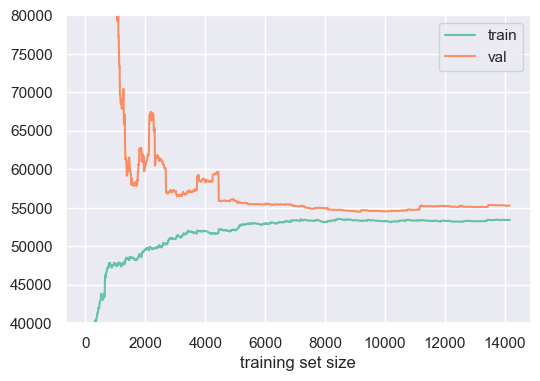

In [12]:
# linear curve for the polynomial model
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X_poly, ytrain)

Initially, the polynomial model overfits a lot: it fits the training data really well (at under 2,000 instances RMSE stays below 50k), and performs very poorly on the validation data (RMSE well above 80k). As the training data size increases, the two curves start to converge, with the validation curve very gradually decreasing. This shows that the addition of extra training data helps to fit better models, and the degree of overfitting gets smaller. More data might help to decrease the error rate even further, although not by a lot: the validation curve appears to stabilize soon.

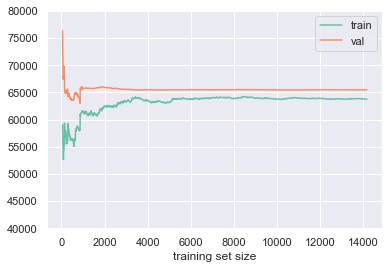

In [13]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, Xtrain, ytrain)

With, linear regression, one can notice that in the beginning, at smaller sizes of training data, the model overfits a little (the training set performance is mainly below 60k, while performance on validation is over 65k at very small sizes of training data; the validation error rate is never as high as with the polynomial model). As the size of the training data increases, the validation set performance stabilizes very quickly and stays on the same level. The training set performance also plateaus at some point and does not change much any more. This indicates that adding more training data will not improve the performance on the validation set.

# Acknowledgement

The notebook is based on the code examples from [Aurélien Géron's textbook](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow".


# Citing this notebook

If you use this notebook in your work, please cite it as follows:
    
Pekar, V. (2024). Machine Learning for Business Analytics. Lecture examples and exercises. (Version 1.0.0). URL: https://github.com/vpekar/bd4dm
